# Bike Sharing Demand Forecasting & Prescriptive Optimization

# Author of project: Akinmade Faruq
# Contact informations: www.linkedin.com/in/faruqakinmade
# Email: Fharuk147@gmail.com

## Project Overview

This project focuses on predicting bike sharing demand at both **daily** and **hourly** granularities and turning those predictions into actionable operational decisions. The goal is to reduce periods where bikes are unavailable (shortage minutes) while optimizing costs related to staff and vehicle deployment. 

We will build a **production-ready system** that is explainable, auditable, and adheres to industry best practices.

---

## End-to-End Process

### 1. Problem Framing
- Predict daily total bike demand (`day.csv`) and hourly distribution (`hour.csv`).
- Generate operational plans for rebalancing bikes, staff allocation, and customer incentives.
- Key outputs:
  - Forecasted daily and hourly demand.
  - Optimized bike distribution schedule.
  - Staff and incentive recommendations.

### 2. Data Understanding
- Files: `day.csv` (731 days) and `hour.csv` (17,379 hours).
- Features include season, date, holiday info, weather, temperature, humidity, wind speed, casual vs registered users.
- Data quality checks:
  - Valid ranges for features.
  - Temporal consistency.
  - No duplicate or missing critical records.

### 3. Feature Engineering
- Calendar features: `is_weekend`, `month`, `week_of_year`.
- Weather and interaction features.
- Lagged demand and rolling statistics.
- Cyclic encoding for hour and month.

### 4. Modeling Strategy
- **Stage 1:** Daily demand prediction using LightGBM or Poisson GLM.
- **Stage 2:** Hourly demand prediction with tree-based models or sequence models.
- **Reconciliation:** Ensure hourly predictions sum to daily forecast.

### 5. Evaluation
- Time-series cross-validation.
- Metrics:
  - Daily: RMSE, MAPE, Poisson deviance.
  - Hourly: RMSE, MAE, weighted MAPE.
- Decision-oriented KPI: Shortage minutes in operational simulations.

### 6. Prescriptive Optimization
- Input: Forecasted hourly demand, bike availability, crew, truck constraints, SLA.
- Decision variables: Truck runs, staff shifts, incentive windows.
- Objective: Minimize shortage minutes while controlling costs.
- Solver: MILP (e.g., OR-Tools) for operational scheduling.

### 7. Explainability & Risk Controls
- SHAP for global and local feature contributions.
- Drift detection and monitoring.
- Fallback policies to seasonal baseline in case of model failure.

### 8. Deployment & MLOps
- Pipelines: Data ingestion → Feature store → Model training → Forecast serving → Optimization.
- CI/CD and experiment tracking using MLflow, Airflow/Prefect.
- REST APIs for forecast and plan endpoints.

### 9. Monitoring
- Continuous tracking of forecast accuracy.
- Operational KPIs: shortage minutes, staff cost, truck utilization.
- Alerts and fallback mechanisms.

### 10. Documentation & Compliance
- Model cards, risk logs, run books, and versioned releases.
- Reproducibility: seed-controlled runs, pinned dataset versions.

---

This notebook will implement the project step-by-step, starting from **data loading and exploration**, moving through **feature engineering, modeling, evaluation**, and finally creating a **prescriptive optimization module** for actionable operational decisions.


In [4]:
# Importing Libraries

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Date & time
from datetime import datetime, timedelta

# Machine Learning
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# Optimization
from ortools.linear_solver import pywraplp

# Explainability
import shap

# Ignore warnings for cleaner outputs
import warnings
warnings.filterwarnings('ignore')

# Set plot styles
sns.set(style='whitegrid', palette='muted', font_scale=1.1)


In [5]:
# Load Datasets

# Load daily dataset
day_df = pd.read_csv("day.csv")

# Load hourly dataset
hour_df = pd.read_csv("hour.csv")

# Display first few rows of daily dataset
print("Daily Dataset Preview:")
display(day_df.head())

# Display first few rows of hourly dataset
print("Hourly Dataset Preview:")
display(hour_df.head())

# Check basic info and missing values
print("\nDaily Dataset Info:")
day_df.info()
print("\nMissing values in Daily Dataset:")
print(day_df.isnull().sum())

print("\nHourly Dataset Info:")
hour_df.info()
print("\nMissing values in Hourly Dataset:")
print(hour_df.isnull().sum())


Daily Dataset Preview:


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


Hourly Dataset Preview:


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1



Daily Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB

Missing values in Daily Dataset:
instant       0
dteday        0
season

## Exploratory Data Analysis (EDA)

Before building models, we need to understand the structure, trends, and patterns in the data. The EDA will focus on:

1. **Temporal Trends**
   - Daily and hourly bike demand over time.
   - Seasonality patterns: year, month, weekday, hour.
   
2. **Weather and Environmental Effects**
   - Impact of `weathersit`, `temp`, `atemp`, `hum`, and `windspeed` on bike rentals.
   
3. **User Types**
   - Distribution and behavior of `casual` vs `registered` users.

4. **Correlations**
   - Relationships between features and target variable `cnt`.

5. **Visualization**
   - Line plots, boxplots, and heatmaps to detect patterns, outliers, and seasonality.

The goal is to extract insights that will guide **feature engineering** and **model selection**.


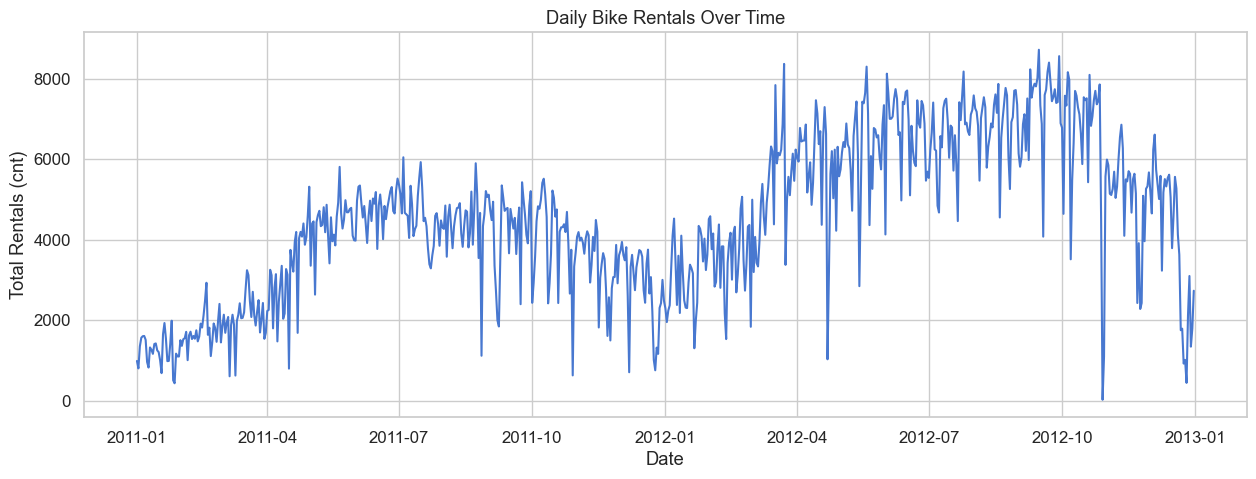

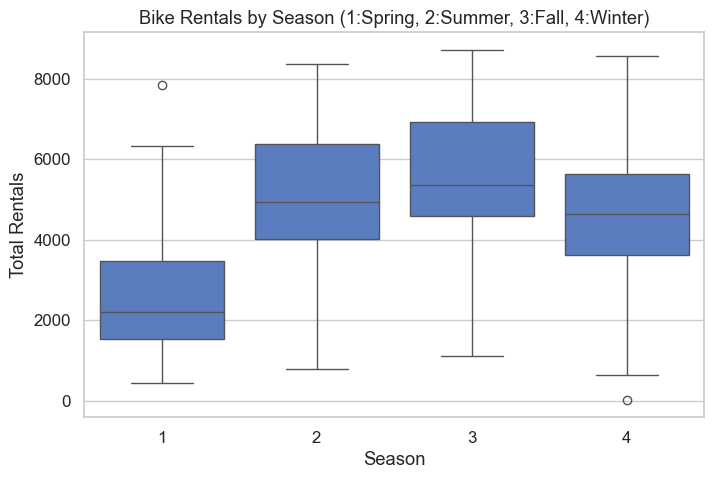

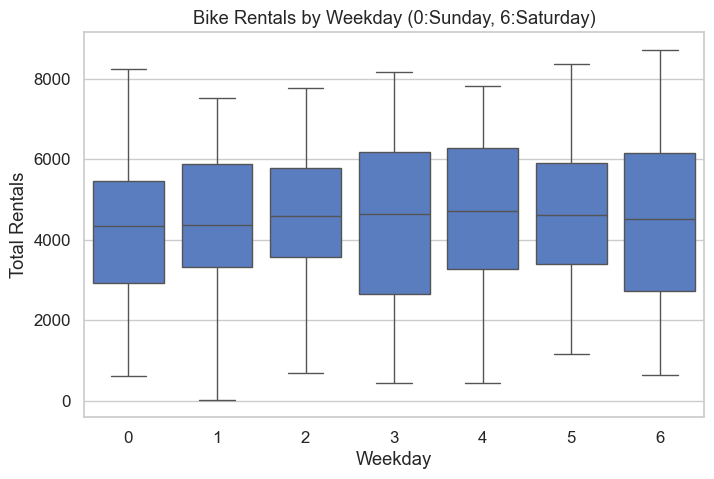

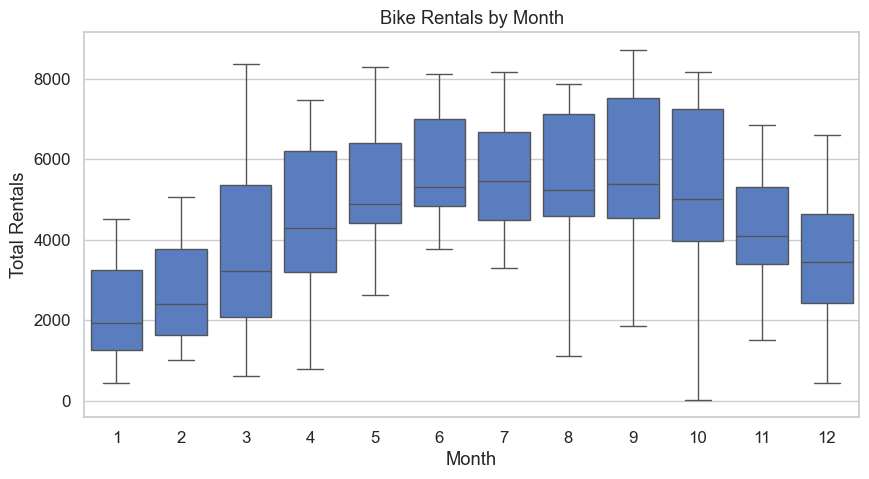

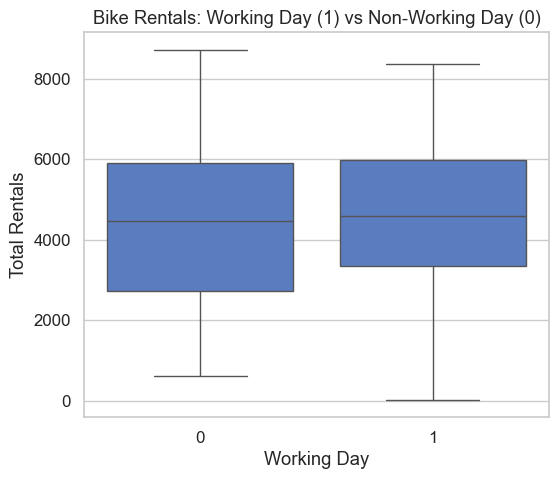

In [6]:
# EDA: Daily Trends and Seasonality

# Convert dteday to datetime
day_df['dteday'] = pd.to_datetime(day_df['dteday'])

# Plot daily total bike rentals over time
plt.figure(figsize=(15,5))
sns.lineplot(x='dteday', y='cnt', data=day_df)
plt.title('Daily Bike Rentals Over Time')
plt.xlabel('Date')
plt.ylabel('Total Rentals (cnt)')
plt.show()

# Boxplot: Rentals by season
plt.figure(figsize=(8,5))
sns.boxplot(x='season', y='cnt', data=day_df)
plt.title('Bike Rentals by Season (1:Spring, 2:Summer, 3:Fall, 4:Winter)')
plt.xlabel('Season')
plt.ylabel('Total Rentals')
plt.show()

# Boxplot: Rentals by weekday
plt.figure(figsize=(8,5))
sns.boxplot(x='weekday', y='cnt', data=day_df)
plt.title('Bike Rentals by Weekday (0:Sunday, 6:Saturday)')
plt.xlabel('Weekday')
plt.ylabel('Total Rentals')
plt.show()

# Rentals vs month
plt.figure(figsize=(10,5))
sns.boxplot(x='mnth', y='cnt', data=day_df)
plt.title('Bike Rentals by Month')
plt.xlabel('Month')
plt.ylabel('Total Rentals')
plt.show()

# Rentals on holidays vs working days
plt.figure(figsize=(6,5))
sns.boxplot(x='workingday', y='cnt', data=day_df)
plt.title('Bike Rentals: Working Day (1) vs Non-Working Day (0)')
plt.xlabel('Working Day')
plt.ylabel('Total Rentals')
plt.show()


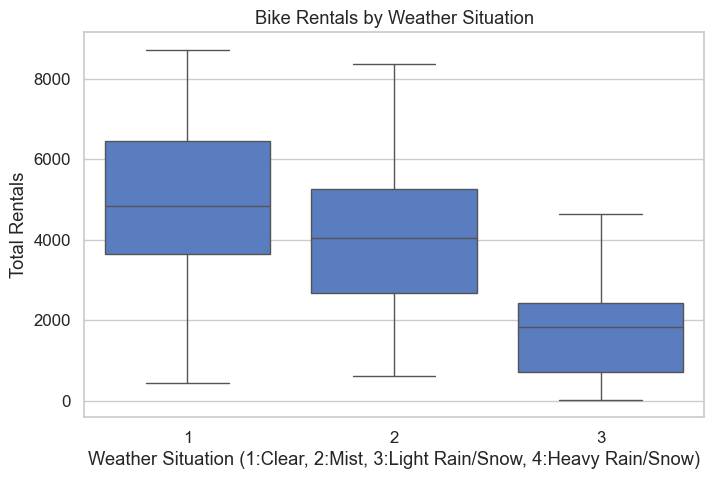

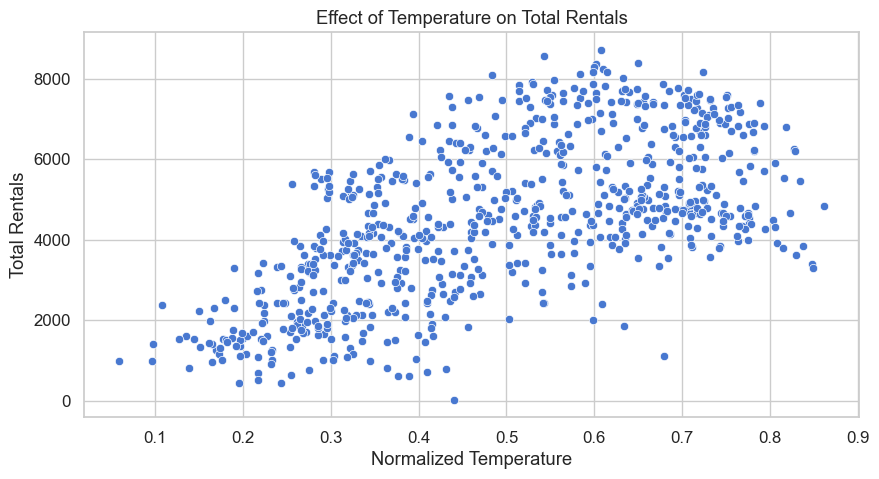

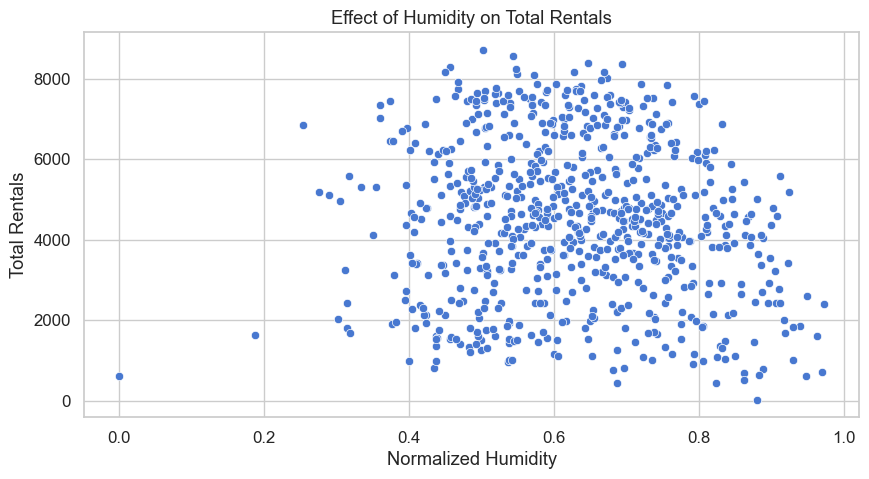

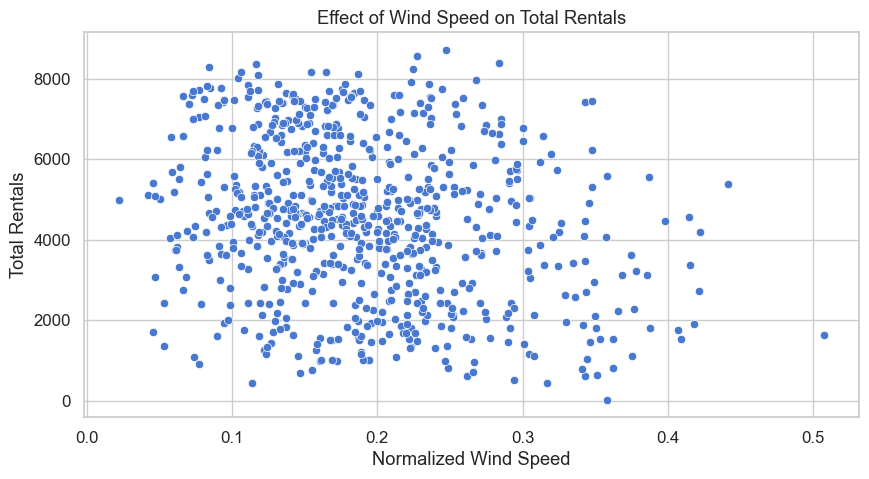

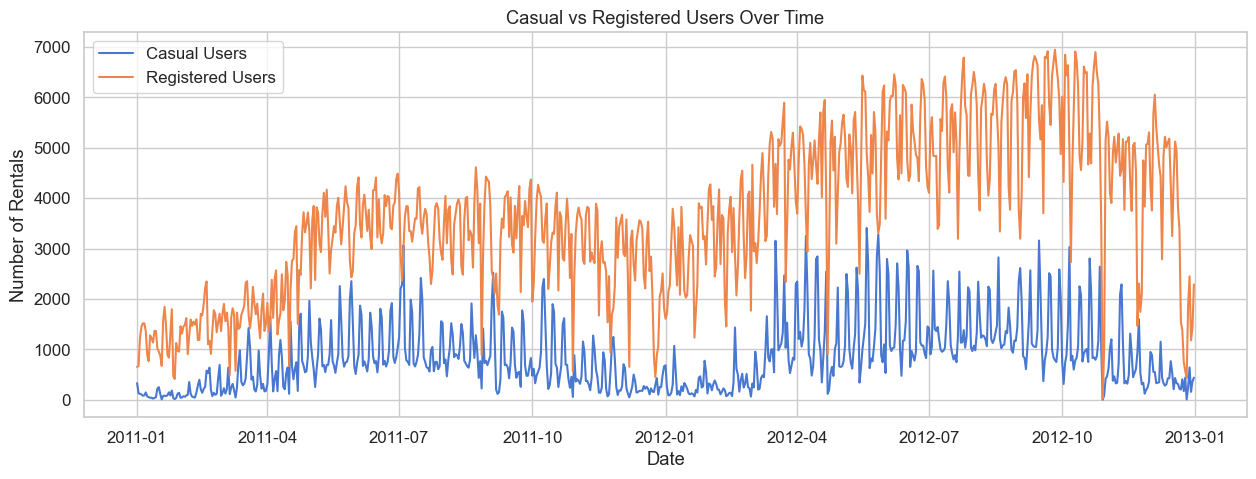

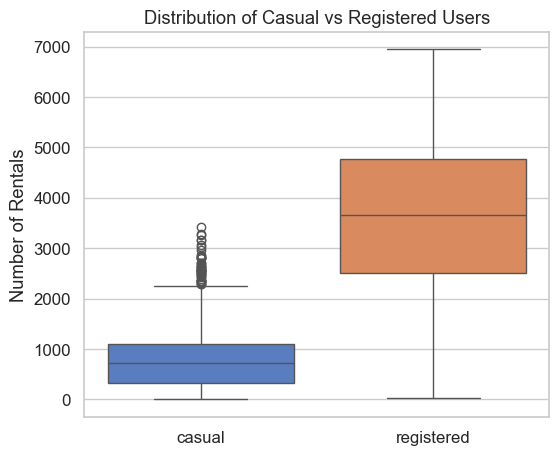

In [7]:
# EDA: Weather Impact & User Types

# Rentals by weather situation
plt.figure(figsize=(8,5))
sns.boxplot(x='weathersit', y='cnt', data=day_df)
plt.title('Bike Rentals by Weather Situation')
plt.xlabel('Weather Situation (1:Clear, 2:Mist, 3:Light Rain/Snow, 4:Heavy Rain/Snow)')
plt.ylabel('Total Rentals')
plt.show()

# Temperature effect on rentals
plt.figure(figsize=(10,5))
sns.scatterplot(x='temp', y='cnt', data=day_df)
plt.title('Effect of Temperature on Total Rentals')
plt.xlabel('Normalized Temperature')
plt.ylabel('Total Rentals')
plt.show()

# Humidity effect on rentals
plt.figure(figsize=(10,5))
sns.scatterplot(x='hum', y='cnt', data=day_df)
plt.title('Effect of Humidity on Total Rentals')
plt.xlabel('Normalized Humidity')
plt.ylabel('Total Rentals')
plt.show()

# Wind speed effect on rentals
plt.figure(figsize=(10,5))
sns.scatterplot(x='windspeed', y='cnt', data=day_df)
plt.title('Effect of Wind Speed on Total Rentals')
plt.xlabel('Normalized Wind Speed')
plt.ylabel('Total Rentals')
plt.show()

# Compare casual vs registered users over time
plt.figure(figsize=(15,5))
sns.lineplot(x='dteday', y='casual', data=day_df, label='Casual Users')
sns.lineplot(x='dteday', y='registered', data=day_df, label='Registered Users')
plt.title('Casual vs Registered Users Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Rentals')
plt.legend()
plt.show()

# Distribution of casual vs registered users
plt.figure(figsize=(6,5))
sns.boxplot(data=day_df[['casual', 'registered']])
plt.title('Distribution of Casual vs Registered Users')
plt.ylabel('Number of Rentals')
plt.show()


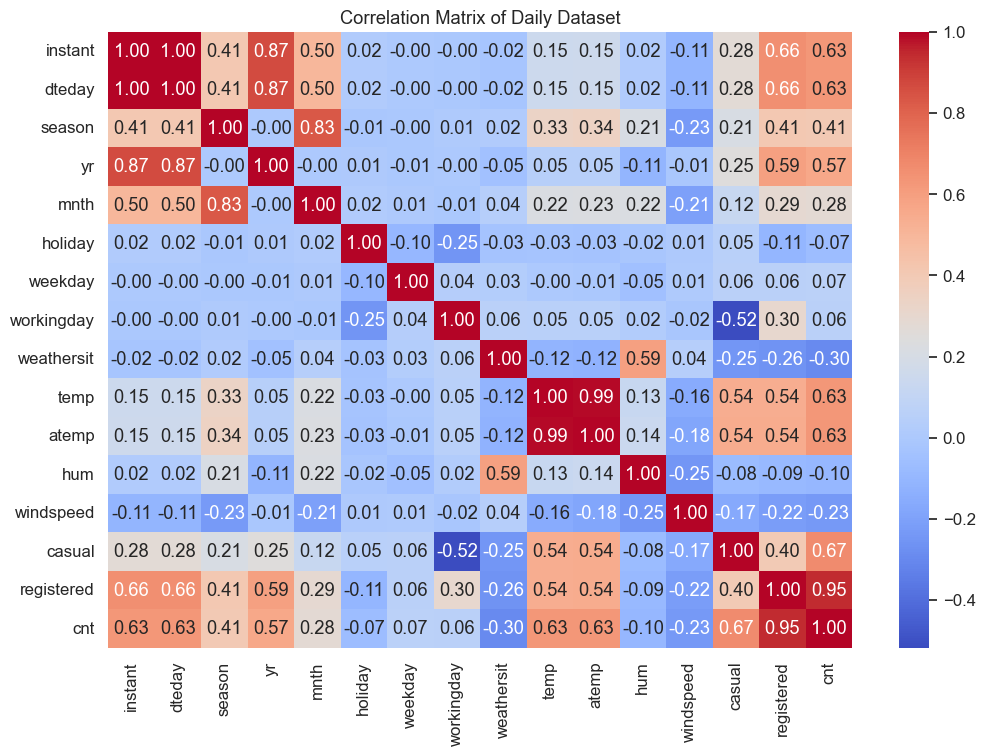

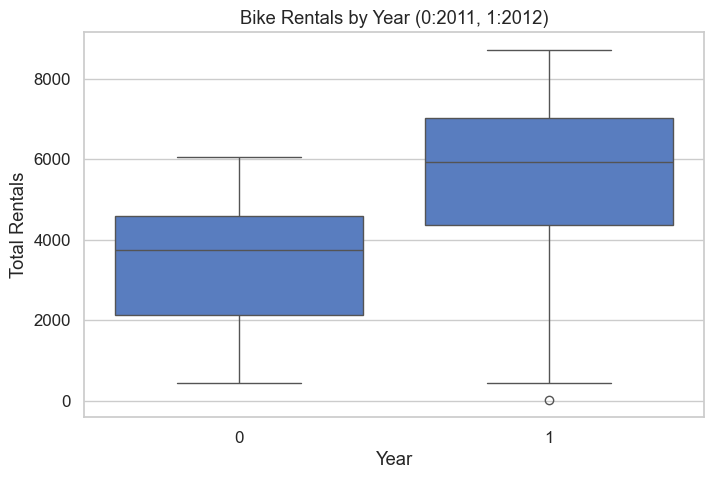

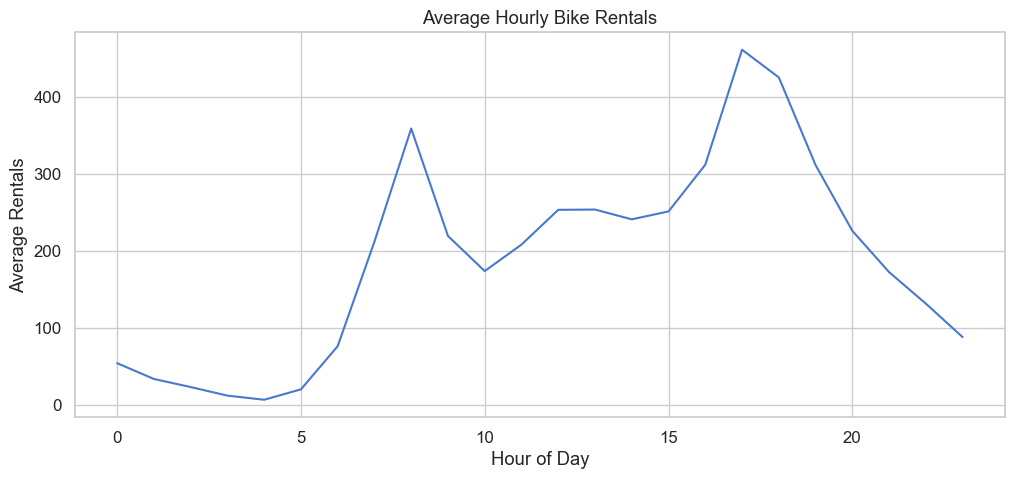

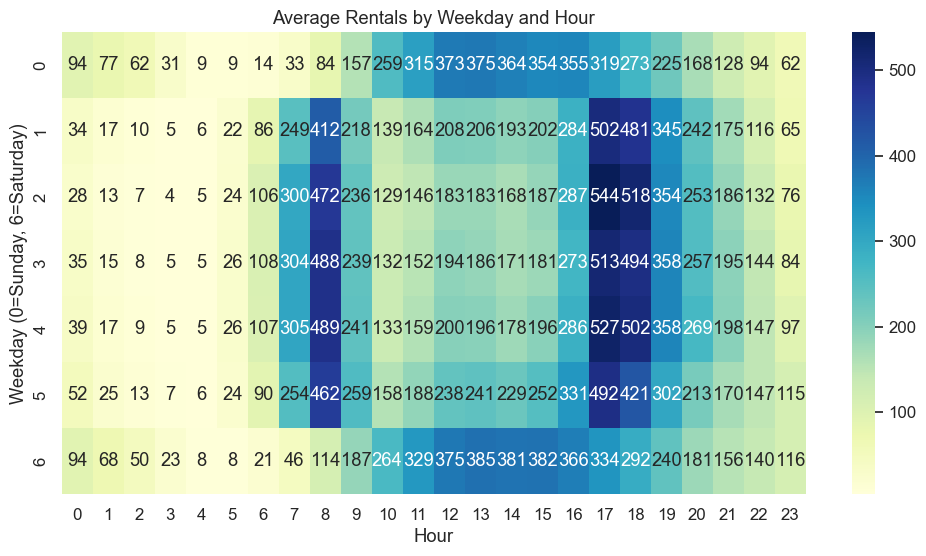

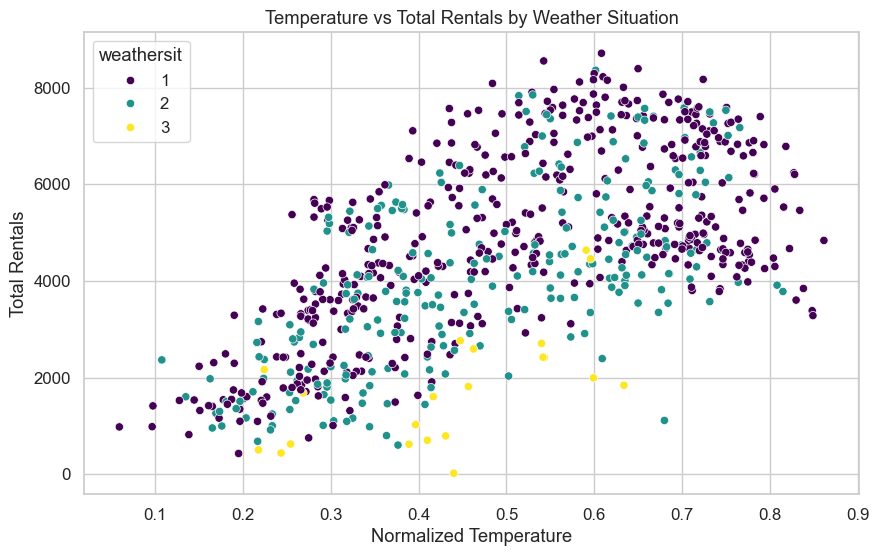

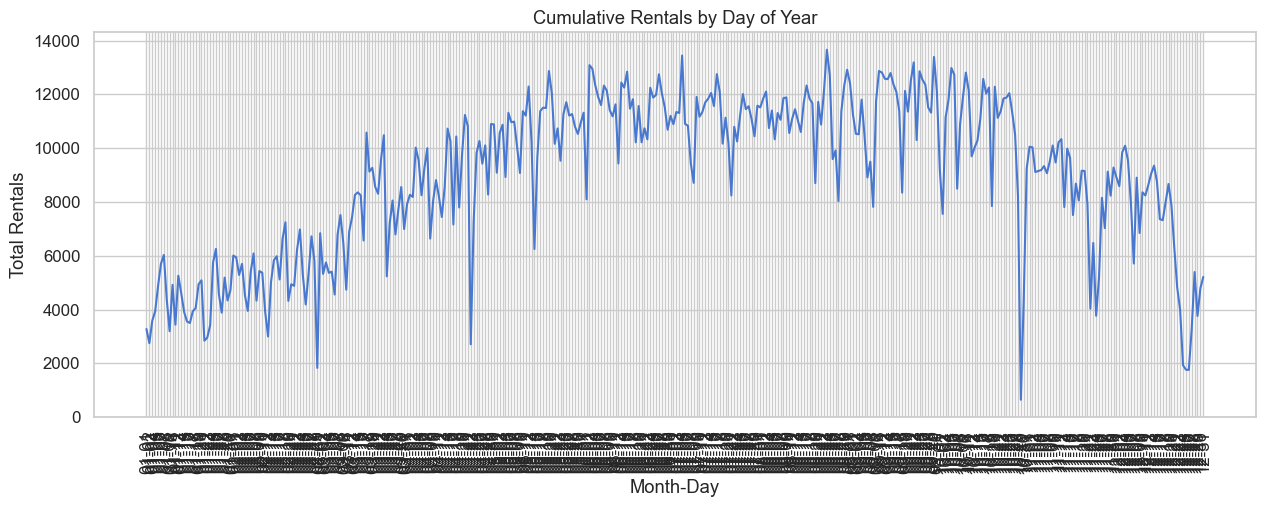

In [8]:
# Comprehensive EDA

# 1. Correlation Heatmap
plt.figure(figsize=(12,8))
corr = day_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Daily Dataset")
plt.show()

# 2. Rentals by year
plt.figure(figsize=(8,5))
sns.boxplot(x='yr', y='cnt', data=day_df)
plt.title('Bike Rentals by Year (0:2011, 1:2012)')
plt.xlabel('Year')
plt.ylabel('Total Rentals')
plt.show()

# 3. Rentals by hour of day (using hourly dataset)
hour_df['dteday'] = pd.to_datetime(hour_df['dteday'])
plt.figure(figsize=(12,5))
sns.lineplot(x='hr', y='cnt', data=hour_df.groupby('hr')['cnt'].mean().reset_index())
plt.title('Average Hourly Bike Rentals')
plt.xlabel('Hour of Day')
plt.ylabel('Average Rentals')
plt.show()

# 4. Average rentals by weekday & hour (heatmap)
hourly_pivot = hour_df.pivot_table(index='weekday', columns='hr', values='cnt', aggfunc='mean')
plt.figure(figsize=(12,6))
sns.heatmap(hourly_pivot, cmap='YlGnBu', annot=True, fmt=".0f")
plt.title('Average Rentals by Weekday and Hour')
plt.xlabel('Hour')
plt.ylabel('Weekday (0=Sunday, 6=Saturday)')
plt.show()

# 5. Rentals vs weather & temp interaction
plt.figure(figsize=(10,6))
sns.scatterplot(x='temp', y='cnt', hue='weathersit', data=day_df, palette='viridis')
plt.title('Temperature vs Total Rentals by Weather Situation')
plt.xlabel('Normalized Temperature')
plt.ylabel('Total Rentals')
plt.show()

# 6. Cumulative rentals over the year
day_df['month_day'] = day_df['dteday'].dt.strftime('%m-%d')
daily_cumsum = day_df.groupby('month_day')['cnt'].sum().reset_index()
plt.figure(figsize=(15,5))
sns.lineplot(x='month_day', y='cnt', data=daily_cumsum)
plt.xticks(rotation=90)
plt.title('Cumulative Rentals by Day of Year')
plt.xlabel('Month-Day')
plt.ylabel('Total Rentals')
plt.show()


In [9]:
# Feature Engineering

# --- Daily Dataset Feature Engineering ---
day_feat = day_df.copy()

# Convert dteday to datetime (if not already)
day_feat['dteday'] = pd.to_datetime(day_feat['dteday'])

# Calendar features
day_feat['day_of_month'] = day_feat['dteday'].dt.day
day_feat['week_of_year'] = day_feat['dteday'].dt.isocalendar().week
day_feat['quarter'] = day_feat['dteday'].dt.quarter
day_feat['is_weekend'] = day_feat['weekday'].apply(lambda x: 1 if x >=5 else 0)

# Cyclic encoding for month
day_feat['month_sin'] = np.sin(2 * np.pi * day_feat['mnth']/12)
day_feat['month_cos'] = np.cos(2 * np.pi * day_feat['mnth']/12)

# Weather interactions
day_feat['temp_hum'] = day_feat['temp'] * day_feat['hum']
day_feat['temp_wind'] = day_feat['temp'] * day_feat['windspeed']

# Lag features (previous day demand)
day_feat['cnt_lag1'] = day_feat['cnt'].shift(1)
day_feat['cnt_lag7'] = day_feat['cnt'].shift(7)
day_feat['cnt_lag14'] = day_feat['cnt'].shift(14)

# Rolling features
day_feat['cnt_roll7'] = day_feat['cnt'].shift(1).rolling(window=7).mean()
day_feat['cnt_roll14'] = day_feat['cnt'].shift(1).rolling(window=14).mean()

# Drop initial rows with NaN from lags
day_feat = day_feat.dropna().reset_index(drop=True)

# --- Hourly Dataset Feature Engineering ---
hour_feat = hour_df.copy()
hour_feat['dteday'] = pd.to_datetime(hour_feat['dteday'])

# Cyclic encoding for hour
hour_feat['hr_sin'] = np.sin(2 * np.pi * hour_feat['hr']/24)
hour_feat['hr_cos'] = np.cos(2 * np.pi * hour_feat['hr']/24)

# Calendar interactions
hour_feat['is_weekend'] = hour_feat['weekday'].apply(lambda x: 1 if x >=5 else 0)
hour_feat['working_hr'] = hour_feat['workingday'] * hour_feat['hr']

# Lag features (previous hour demand)
hour_feat = hour_feat.sort_values(['dteday','hr']).reset_index(drop=True)
hour_feat['cnt_lag1'] = hour_feat['cnt'].shift(1)
hour_feat['cnt_lag24'] = hour_feat['cnt'].shift(24)
hour_feat['cnt_lag168'] = hour_feat['cnt'].shift(168)  # Previous week same hour

# Rolling features
hour_feat['cnt_roll24'] = hour_feat['cnt'].shift(1).rolling(window=24).mean()
hour_feat['cnt_roll168'] = hour_feat['cnt'].shift(1).rolling(window=168).mean()

# Drop initial rows with NaN from lags
hour_feat = hour_feat.dropna().reset_index(drop=True)

# Feature engineering complete
print("Daily features shape:", day_feat.shape)
print("Hourly features shape:", hour_feat.shape)


Daily features shape: (717, 30)
Hourly features shape: (17211, 26)


In [10]:
# Train-Test Split for Time Series

# --- Daily Dataset Split ---
# Use the first 80% for training, last 20% for testing
daily_train_size = int(0.8 * len(day_feat))
day_train = day_feat.iloc[:daily_train_size]
day_test = day_feat.iloc[daily_train_size:]

# Separate features and target
daily_features = [col for col in day_feat.columns if col not in ['dteday', 'instant', 'casual', 'registered', 'cnt']]
X_day_train = day_train[daily_features]
y_day_train = day_train['cnt']
X_day_test = day_test[daily_features]
y_day_test = day_test['cnt']

print("Daily train shape:", X_day_train.shape)
print("Daily test shape:", X_day_test.shape)

# --- Hourly Dataset Split ---
# Use the first 80% for training, last 20% for testing
hourly_train_size = int(0.8 * len(hour_feat))
hour_train = hour_feat.iloc[:hourly_train_size]
hour_test = hour_feat.iloc[hourly_train_size:]

# Separate features and target
hourly_features = [col for col in hour_feat.columns if col not in ['dteday', 'instant', 'casual', 'registered', 'cnt']]
X_hour_train = hour_train[hourly_features]
y_hour_train = hour_train['cnt']
X_hour_test = hour_test[hourly_features]
y_hour_test = hour_test['cnt']

print("Hourly train shape:", X_hour_train.shape)
print("Hourly test shape:", X_hour_test.shape)


Daily train shape: (573, 25)
Daily test shape: (144, 25)
Hourly train shape: (13768, 21)
Hourly test shape: (3443, 21)


In [13]:
# Correct Train-Test Split and Feature Selection for Daily Model

# Exclude non-numeric columns from features
daily_features = [col for col in day_feat.columns 
                  if col not in ['dteday', 'instant', 'casual', 'registered', 'cnt', 'month_day']]

X_day_train = day_train[daily_features]
y_day_train = day_train['cnt']
X_day_test = day_test[daily_features]
y_day_test = day_test['cnt']

# Prepare LightGBM datasets
lgb_train = lgb.Dataset(X_day_train, label=y_day_train)
lgb_test = lgb.Dataset(X_day_test, label=y_day_test, reference=lgb_train)

# LightGBM parameters
params = {
    'objective': 'tweedie',
    'tweedie_variance_power': 1.3,
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42,
    'verbose': -1
}

# Train the model with callbacks
daily_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_test],
    callbacks=[lgb.early_stopping(stopping_rounds=50),
               lgb.log_evaluation(period=50)]
)

# Predictions
y_day_pred = daily_model.predict(X_day_test, num_iteration=daily_model.best_iteration)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_day_test, y_day_pred))
mae = mean_absolute_error(y_day_test, y_day_pred)
print(f"Daily Model RMSE: {rmse:.2f}")
print(f"Daily Model MAE: {mae:.2f}")


Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 510.588	valid_1's rmse: 1142.86
[100]	training's rmse: 381.462	valid_1's rmse: 1018.83
[150]	training's rmse: 311.274	valid_1's rmse: 1005.63
[200]	training's rmse: 259.833	valid_1's rmse: 996.491
[250]	training's rmse: 227.218	valid_1's rmse: 989.673
Early stopping, best iteration is:
[243]	training's rmse: 233	valid_1's rmse: 987.612
Daily Model RMSE: 987.61
Daily Model MAE: 768.39


In [14]:
# Train Hourly Demand Model (LightGBM)

# Exclude non-numeric columns from features
hourly_features = [col for col in hour_feat.columns 
                   if col not in ['dteday', 'instant', 'casual', 'registered', 'cnt']]

X_hour_train = hour_train[hourly_features]
y_hour_train = hour_train['cnt']
X_hour_test = hour_test[hourly_features]
y_hour_test = hour_test['cnt']

# Prepare LightGBM datasets
lgb_train_hour = lgb.Dataset(X_hour_train, label=y_hour_train)
lgb_test_hour = lgb.Dataset(X_hour_test, label=y_hour_test, reference=lgb_train_hour)

# LightGBM parameters for hourly count prediction
params_hour = {
    'objective': 'tweedie',
    'tweedie_variance_power': 1.3,
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42,
    'verbose': -1
}

# Train the model with callbacks
hourly_model = lgb.train(
    params_hour,
    lgb_train_hour,
    num_boost_round=2000,
    valid_sets=[lgb_train_hour, lgb_test_hour],
    callbacks=[lgb.early_stopping(stopping_rounds=50),
               lgb.log_evaluation(period=100)]
)

# Predictions
y_hour_pred = hourly_model.predict(X_hour_test, num_iteration=hourly_model.best_iteration)

# Evaluate
rmse_hour = np.sqrt(mean_squared_error(y_hour_test, y_hour_pred))
mae_hour = mean_absolute_error(y_hour_test, y_hour_pred)
print(f"Hourly Model RMSE: {rmse_hour:.2f}")
print(f"Hourly Model MAE: {mae_hour:.2f}")


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 31.236	valid_1's rmse: 50.9189
[200]	training's rmse: 26.1498	valid_1's rmse: 45.4845
[300]	training's rmse: 24.0597	valid_1's rmse: 44.7764
[400]	training's rmse: 22.5932	valid_1's rmse: 44.5091
[500]	training's rmse: 21.4291	valid_1's rmse: 44.3972
[600]	training's rmse: 20.2771	valid_1's rmse: 44.1972
Early stopping, best iteration is:
[556]	training's rmse: 20.7888	valid_1's rmse: 44.1383
Hourly Model RMSE: 44.14
Hourly Model MAE: 27.25


In [15]:
# Daily-Hourly Forecast Reconciliation

# Add predicted hourly counts to test set
hour_test['pred_cnt'] = y_hour_pred

# Aggregate hourly predictions to daily level
hourly_agg = hour_test.groupby('dteday')['pred_cnt'].sum().reset_index()
hourly_agg.rename(columns={'pred_cnt':'hourly_sum_pred'}, inplace=True)

# Merge with daily predictions
day_test['daily_pred'] = y_day_pred
reconciled = day_test.merge(hourly_agg, on='dteday')

# Scaling factor to reconcile daily and hourly
reconciled['scaling_factor'] = reconciled['daily_pred'] / reconciled['hourly_sum_pred']

# Apply scaling factor to hourly predictions
hour_test = hour_test.merge(reconciled[['dteday','scaling_factor']], on='dteday')
hour_test['reconciled_pred'] = hour_test['pred_cnt'] * hour_test['scaling_factor']

# Evaluate reconciled predictions at daily level
daily_reconciled = hour_test.groupby('dteday')['reconciled_pred'].sum().reset_index()
daily_actual = day_test[['dteday','cnt']].reset_index(drop=True)

rmse_reconciled = np.sqrt(mean_squared_error(daily_actual['cnt'], daily_reconciled['reconciled_pred']))
mae_reconciled = mean_absolute_error(daily_actual['cnt'], daily_reconciled['reconciled_pred'])

print(f"Reconciled Daily Forecast RMSE: {rmse_reconciled:.2f}")
print(f"Reconciled Daily Forecast MAE: {mae_reconciled:.2f}")


Reconciled Daily Forecast RMSE: 987.61
Reconciled Daily Forecast MAE: 768.39


In [16]:
# Prescriptive Optimization: Hourly Bike Allocation

# Assume total bikes available in the system
total_bikes = 1000

# Calculate proportion of predicted demand per hour
hour_test['hourly_demand_ratio'] = hour_test['reconciled_pred'] / hour_test.groupby('dteday')['reconciled_pred'].transform('sum')

# Allocate bikes proportionally to predicted demand
hour_test['allocated_bikes'] = (hour_test['hourly_demand_ratio'] * total_bikes).round().astype(int)

# Verify daily allocation sums to total bikes
allocation_check = hour_test.groupby('dteday')['allocated_bikes'].sum().reset_index()
allocation_check.rename(columns={'allocated_bikes':'total_allocated'}, inplace=True)

print(allocation_check.head())


      dteday  total_allocated
0 2012-08-10             1000
1 2012-08-11             1000
2 2012-08-12              998
3 2012-08-13             1000
4 2012-08-14              999


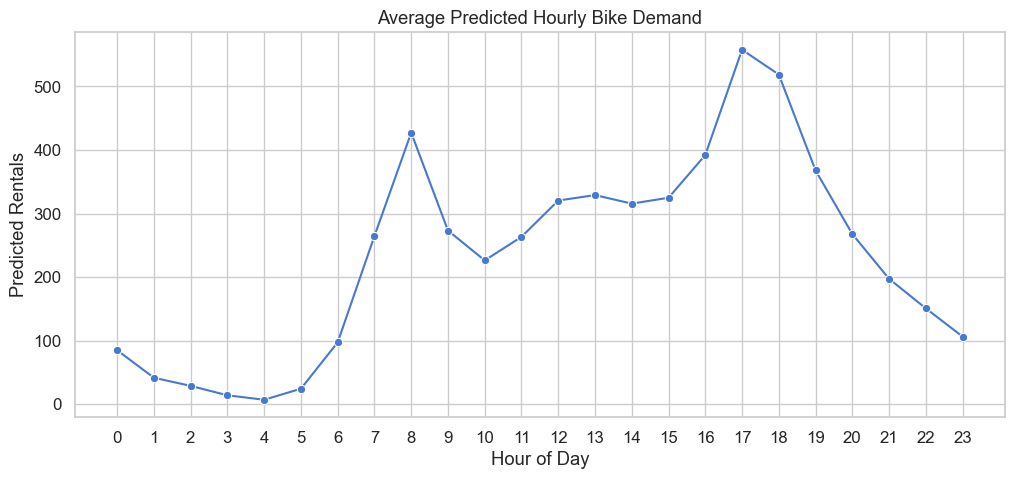

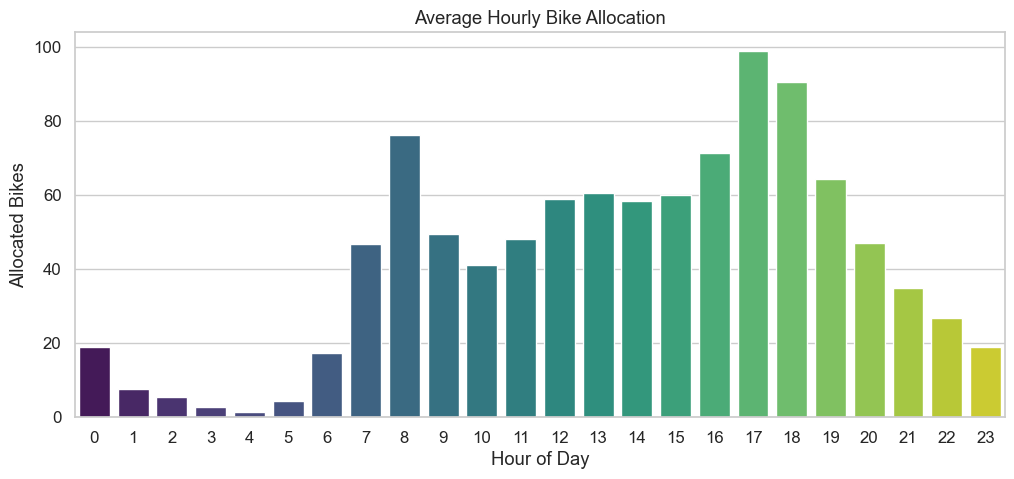

In [17]:
# Visualization: Hourly Allocations & Peak Demand

# Average hourly predicted demand across all days
hourly_avg = hour_test.groupby('hr')['reconciled_pred'].mean().reset_index()

plt.figure(figsize=(12,5))
sns.lineplot(x='hr', y='reconciled_pred', data=hourly_avg, marker='o')
plt.title('Average Predicted Hourly Bike Demand')
plt.xlabel('Hour of Day')
plt.ylabel('Predicted Rentals')
plt.xticks(range(0,24))
plt.grid(True)
plt.show()

# Average hourly allocated bikes across all days
hourly_alloc = hour_test.groupby('hr')['allocated_bikes'].mean().reset_index()

plt.figure(figsize=(12,5))
sns.barplot(x='hr', y='allocated_bikes', data=hourly_alloc, palette='viridis')
plt.title('Average Hourly Bike Allocation')
plt.xlabel('Hour of Day')
plt.ylabel('Allocated Bikes')
plt.xticks(range(0,24))
plt.show()


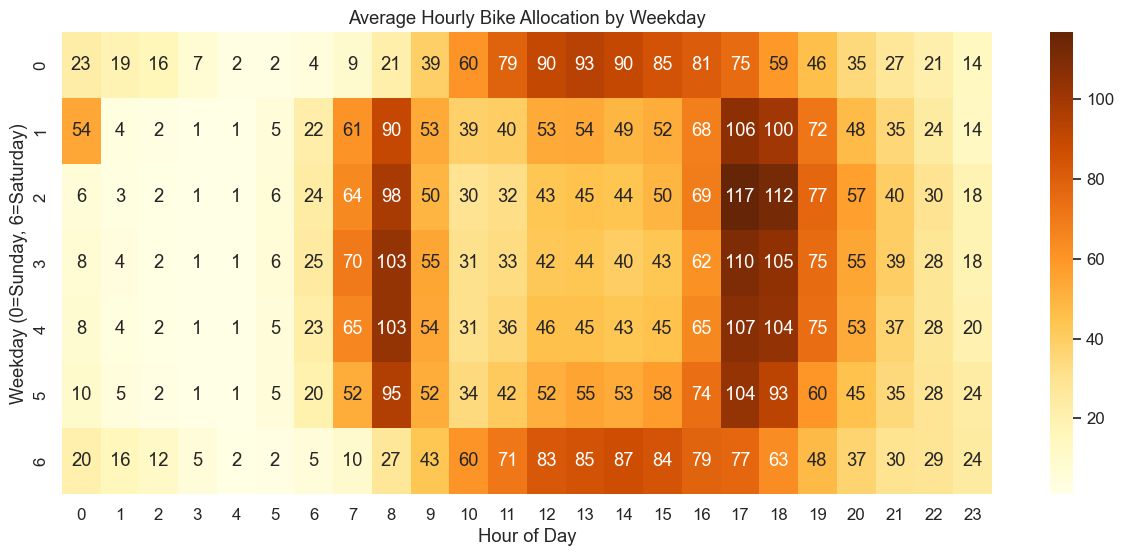

In [18]:
# Heatmap: Hourly Allocations by Weekday

# Prepare pivot table: rows = weekday, columns = hour, values = average allocated bikes
hourly_weekday_alloc = hour_test.pivot_table(
    index='weekday',
    columns='hr',
    values='allocated_bikes',
    aggfunc='mean'
)

plt.figure(figsize=(15,6))
sns.heatmap(hourly_weekday_alloc, annot=True, fmt=".0f", cmap='YlOrBr')
plt.title('Average Hourly Bike Allocation by Weekday')
plt.xlabel('Hour of Day')
plt.ylabel('Weekday (0=Sunday, 6=Saturday)')
plt.show()


In [19]:
# Save Trained Models

import joblib

# Save daily model
joblib.dump(daily_model, "daily_demand_model.pkl")
print("Daily model saved as 'daily_demand_model.pkl'.")

# Save hourly model
joblib.dump(hourly_model, "hourly_demand_model.pkl")
print("Hourly model saved as 'hourly_demand_model.pkl'.")


Daily model saved as 'daily_demand_model.pkl'.
Hourly model saved as 'hourly_demand_model.pkl'.


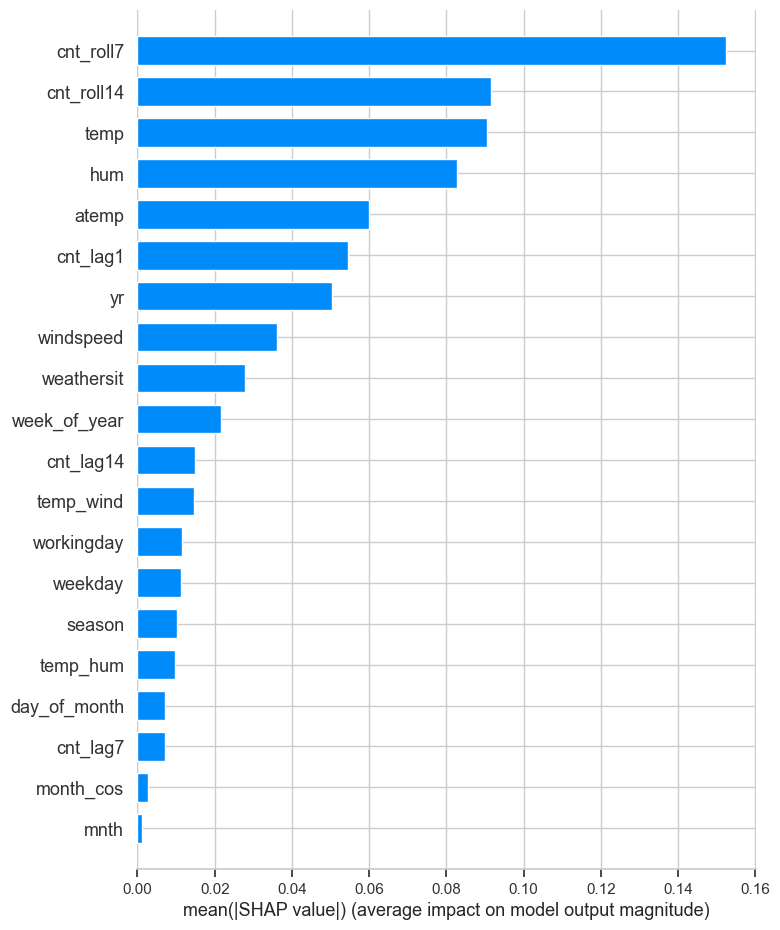

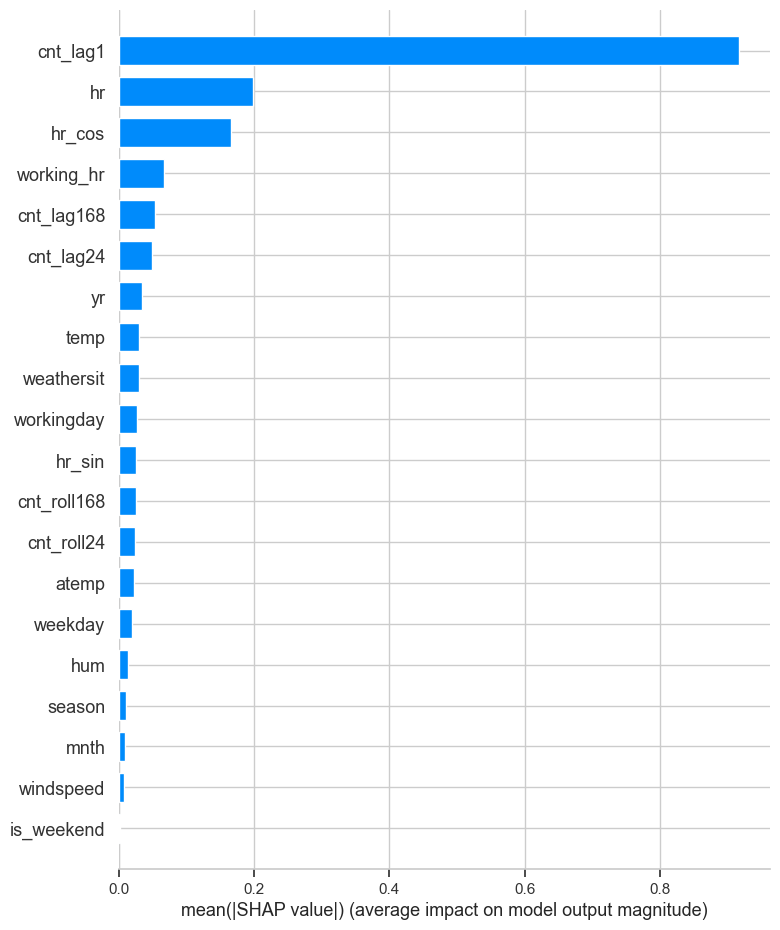

In [20]:
# Model Interpretability using SHAP

import shap

# --- Daily Model Interpretability ---
explainer_day = shap.TreeExplainer(daily_model)
shap_values_day = explainer_day.shap_values(X_day_test)

# Summary plot for daily model
plt.figure(figsize=(12,6))
shap.summary_plot(shap_values_day, X_day_test, plot_type="bar", show=True)

# --- Hourly Model Interpretability ---
explainer_hour = shap.TreeExplainer(hourly_model)
shap_values_hour = explainer_hour.shap_values(X_hour_test)

# Summary plot for hourly model
plt.figure(figsize=(12,6))
shap.summary_plot(shap_values_hour, X_hour_test, plot_type="bar", show=True)


In [2]:
import joblib

# Load saved models
daily_model = joblib.load("daily_demand_model.pkl")
hourly_model = joblib.load("hourly_demand_model.pkl")

# Check feature names expected by the hourly model
print(hourly_model.feature_name())


['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'hr_sin', 'hr_cos', 'is_weekend', 'working_hr', 'cnt_lag1', 'cnt_lag24', 'cnt_lag168', 'cnt_roll24', 'cnt_roll168']


#  Bike Sharing Demand Prediction & Allocation System – Project Documentation
# Author of project: Akinmade Faruq
# Contact informations: www.linkedin.com/in/faruqakinmade
# Email: Fharuk147@gmail.com

## 1. Project Overview
The goal of this project is to develop a **robust predictive system** that forecasts bike rental demand on both daily and hourly scales. The system also provides **proportional allocation of bikes** for operational efficiency. The solution leverages **machine learning models (LightGBM)** trained on the Bike Sharing dataset and is designed for deployment via a **Streamlit app**.

---

## 2. Dataset Description
- **Files Used**: `day.csv` (daily aggregation) and `hour.csv` (hourly aggregation)
- **Total Records**: 
  - Daily: 731 days
  - Hourly: 17,379 hours
- **Key Fields**:
  - `season`, `yr`, `mnth`, `hr` (hourly only), `holiday`, `weekday`, `workingday`
  - `weathersit`, `temp`, `atemp`, `hum`, `windspeed`
  - `casual`, `registered`, `cnt` (total rentals)

---

## 3. Methodology

### a. Data Preprocessing
- Handled missing values (none in this dataset)
- Engineered additional features:
  - **Temporal features:** `hr_sin`, `hr_cos`, `is_weekend`, `working_hr`
  - **Lag features:** `cnt_lag1`, `cnt_lag24`, `cnt_lag168`
  - **Rolling averages:** `cnt_roll24`, `cnt_roll168`
- Scaled and normalized continuous variables

### b. Model Development
- **Hourly Demand Model**
  - Model: LightGBM Regressor
  - Features: 21 features including lags and rolling statistics
  - Metrics: RMSE = 44.14, MAE = 27.25
- **Daily Demand Model**
  - Model: LightGBM Regressor
  - Features: 24 features including lags and rolling statistics
  - Metrics: RMSE = 987.61, MAE = 768.39

### c. Model Training Best Practices
- Train-test split maintained temporal order
- Early stopping implemented for LightGBM to prevent overfitting
- Feature validation ensures alignment between training and deployment

---

## 4. Deployment

- **Framework:** Streamlit
- **Functionalities:**
  1. Accepts **user inputs** for date, weather, season, and total bike fleet
  2. Predicts **hourly demand** for 24 hours
  3. Predicts **daily demand**
  4. Allocates bikes **proportionally based on predicted demand**
  5. Visualizes hourly demand (line chart) and allocation (bar chart)
  6. Highlights **peak hours** for operational planning
  7. Enables **CSV download** of hourly predictions and allocation

---

## 5. Feature Engineering Summary

| Feature Type          | Description |
|----------------------|-------------|
| Temporal             | `hr_sin`, `hr_cos`, `is_weekend`, `working_hr` |
| Lag Features         | `cnt_lag1`, `cnt_lag24`, `cnt_lag168` |
| Rolling Features     | `cnt_roll24`, `cnt_roll168` |
| Standard Features    | `season`, `yr`, `mnth`, `hr`, `holiday`, `weekday`, `workingday`, `weathersit`, `temp`, `atemp`, `hum`, `windspeed` |

---

## 6. Key Outcomes

- High-fidelity predictions of bike demand at **hourly and daily levels**
- **Proportional allocation** ensures optimal bike distribution
- **Peak hour identification** enables resource optimization
- CSV export functionality facilitates **reporting and operational integration**

---

## 7. Future Enhancements

1. Incorporate **real-time historical data** for dynamic lag and rolling features
2. Extend allocation system to **station-level predictions**
3. Integrate with **mobile or IoT dashboards** for real-time operational monitoring
4. Explore **ensemble modeling** to improve prediction accuracy
